# iSDA soil data

* **Products used:** 
[gm_s2_annual](https://explorer.digitalearth.africa/gm_s2_annual)


## Background
iSDAsoil is an open access soils data resource for the African continent.

## Description
This notebook demonstrates how to integrate this data with DE Africa products and workflows. For technical information in iSDAsoil, see [Miller et al. 2021](https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.3001441). The code in this notebook has been adapted from the [iSDA-Africa GitHub](https://github.com/iSDA-Africa).

1. Load iSDA data
2. Visualise iSDA against DE Africa products

***

## Getting started

Provide any particular instructions that the user might need, e.g. To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

Use standard import commands; some are shown below. 
Begin with any `iPython` magic commands, followed by standard Python packages, then any additional functionality you need from the `Tools` package.

In [1]:
%matplotlib inline

import datacube
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import rasterio as rio
from pyproj import Transformer
import matplotlib.pyplot as plt
import os
import numpy as np

from urllib.parse import urlparse
import boto3
from pystac import stac_io, Catalog
from deafrica_tools.plotting import display_map, rgb

#this function allows us to directly query the data on s3
def my_read_method(uri):
    parsed = urlparse(uri)
    if parsed.scheme == 's3':
        bucket = parsed.netloc
        key = parsed.path[1:]
        s3 = boto3.resource('s3')
        obj = s3.Object(bucket, key)
        return obj.get()['Body'].read().decode('utf-8')
    else:
        return stac_io.default_read_text_method(uri)

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


### Connect to the datacube

Connect to the datacube so we can access DE Africa data.

In [2]:
dc = datacube.Datacube(app='iSDA_soil')

## View available iSDA data

In [3]:
stac_io.read_text_method = my_read_method

catalog = Catalog.from_file("https://isdasoil.s3.amazonaws.com/catalog.json")

assets = {}

for root, catalogs, items in catalog.walk():
    for item in items:
        print(f"Type: {item.get_parent().title}")
        # save all items to a dictionary as we go along
        assets[item.id] = item
        for asset in item.assets.values():
            if asset.roles == ['data']:
                print(f"Title: {asset.title}")
                print(f"Description: {asset.description}")
                print(f"URL: {asset.href}")
                print("------------")

Type: Soil data
Title: Aluminium, extractable
Description: Aluminium, extractable (log transformed) at soil depths of 0-20cm and 20-50cm, predicted mean and standard deviation
URL: https://isdasoil.s3.amazonaws.com/soil_data/aluminium_extractable/aluminium_extractable.tif
------------
Type: Soil data
Title: Depth to bedrock
Description: Depth to bedrock at 0-200cm depth, predicted mean and standard deviation
URL: https://isdasoil.s3.amazonaws.com/soil_data/bedrock_depth/bedrock_depth.tif
------------
Type: Soil data
Title: Bulk density, <2mm fraction
Description: Bulk density, <2mm fraction at soil depths of 0-20cm and 20-50cm, predicted mean and standard deviation
URL: https://isdasoil.s3.amazonaws.com/soil_data/bulk_density/bulk_density.tif
------------
Type: Soil data
Title: Calcium, extractable
Description: Calcium, extractable (log transformed) at soil depths of 0-20cm and 20-50cm, predicted mean and standard deviation
URL: https://isdasoil.s3.amazonaws.com/soil_data/calcium_extra

### Define region of interest

In [4]:
lat = -32.9
lon = 18.7
buffer = 0.5

display_map((lon - buffer, lon + buffer), (lat - buffer, lat + buffer))

## Get iSDA Data

Here, we define a function for bringing in iSDA data.

In [5]:
def get_data_subset(start_lat_lon, end_lat_lon, file_location):
    '''
    :param start_lat_lon: upper left corner of the bounding box as lat, lon
    :param end_lat_lon: lower right corner of the bounding box as lat, lon
    :param file_location: location of file
    :return: numpy array of the dataset, metadata required for writing back to tiff file
    '''
    with rio.open(file_location) as file:
        transformer = Transformer.from_crs("epsg:4326", file.crs)

        # convert the data from lat/lon to x,y coords of the source dataset crs
        start_coords = transformer.transform(start_lat_lon[0], start_lat_lon[1])
        end_coords = transformer.transform(end_lat_lon[0], end_lat_lon[1])

        # get the location of the pixel at the given location (in lon/lat (x/y) order))
        start_coords= file.index(start_coords[0], start_coords[1])
        end_coords=file.index(end_coords[0], end_coords[1])

        window = rio.windows.Window(start_coords[1], start_coords[0], end_coords[1] - start_coords[1], end_coords[0] - start_coords[0])


        arr = file.read(window=window)

        new_profile = file.profile.copy()

    new_profile.update({
            'height': window.height,
            'width': window.width,
            'count': file.count,
            'transform': file.window_transform(window)
    }) 

    return arr, new_profile

In [6]:
fcc_data, fcc_metadata = get_data_subset((lat + buffer, lon - buffer), (lat - buffer, lon + buffer), assets["fcc"].assets["image"].href)

In [7]:
conversion_funcs = {
    "x": np.vectorize(lambda x: x),
    "x/10": np.vectorize(lambda x: x/10, otypes=["float32"]),
    "x/100": np.vectorize(lambda x: x/100, otypes=["float32"]),
    "expm1(x/10)": np.vectorize(lambda x: np.expm1(x / 10), otypes=["float32"]),
    "%3000": np.vectorize(lambda x: int(x%3000), otypes=["int16"])
}


fcc_conversion = conversion=assets['fcc'].extra_fields["back-transformation"]
fcc_data = conversion_funcs[fcc_conversion](fcc_data)

#get the metadata file
fcc_labels = pd.read_csv(assets['fcc'].assets["metadata"].href, index_col=0)

mappings = {val:fcc_labels.loc[int(val),"Description"] for val in np.unique(fcc_data)}

# print the numeric values stored in the file alongside their string representation
mappings

{0: 'No constraints',
 2: 'Gravelly',
 4: 'Slope',
 6: 'Gravelly, Slope',
 8: 'High erosion risk - textual contrast',
 12: 'Slope, High erosion risk - textual contrast',
 36: 'Slope, High erosion risk - steep slope',
 38: 'Gravelly, Slope, High erosion risk - steep slope',
 44: 'Slope, High erosion risk - textual contrast, High erosion risk - steep slope',
 256: 'Calcareous',
 264: 'High erosion risk - textual contrast, Calcareous',
 512: 'Low K',
 516: 'Slope, Low K',
 520: 'High erosion risk - textual contrast, Low K',
 524: 'Slope, High erosion risk - textual contrast, Low K',
 548: 'Slope, High erosion risk - steep slope, Low K',
 556: 'Slope, High erosion risk - textual contrast, High erosion risk - steep slope, Low K',
 768: 'Calcareous, Low K',
 776: 'High erosion risk - textual contrast, Calcareous, Low K',
 1024: 'High leaching potential',
 1028: 'Slope, High leaching potential',
 1032: 'High erosion risk - textual contrast, High leaching potential',
 1060: 'Slope, High erosio

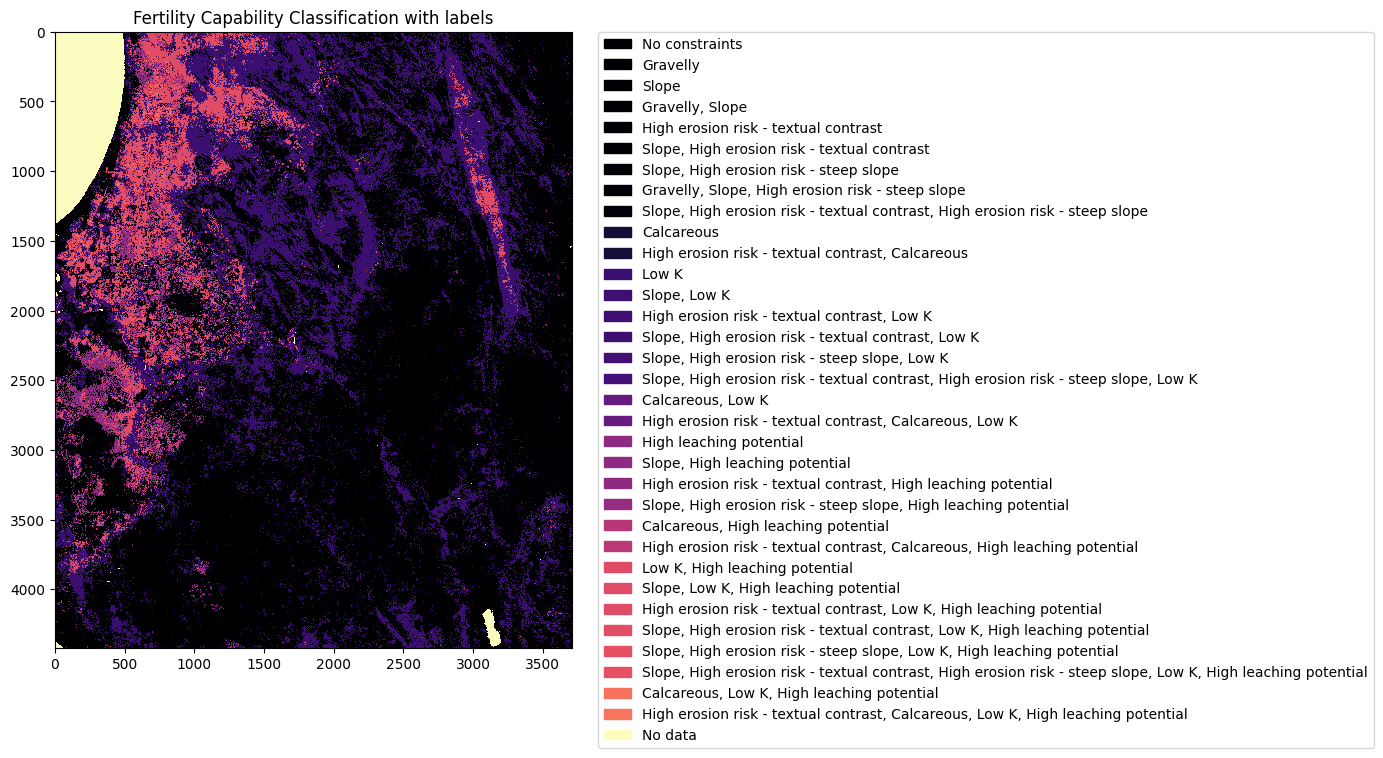

In [8]:
plt.figure(figsize=(12,8), dpi= 100)
im = plt.imshow(fcc_data[0], cmap="magma", interpolation='none')
colors = [ im.cmap(im.norm(value)) for value in np.unique(fcc_data[0])]
patches = [mpatches.Patch(color=colors[idx], label=str(mappings[val])) for idx, val in enumerate(np.unique(fcc_data[0]))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.title("Fertility Capability Classification with labels")
plt.show()

## Clay
Bring in clay data.

In [9]:
clay_data, clay_metadata = get_data_subset((lat + buffer, lon - buffer), (lat - buffer, lon + buffer), assets["clay_content"].assets["image"].href)

clay_data=clay_data.astype('float')

# Convert missing values to NaN
clay_data[clay_data == 255] = np.NAN

In [10]:
bands = assets["clay_content"].assets["image"].extra_fields.get('eo:bands')
bands = [val['description'] for val in bands]
bands

['Clay content, predicted mean at 0-20 cm depth',
 'Clay content, predicted mean at 20-50 cm depth',
 'Clay content, standard deviation at 0-20 cm depth',
 'Clay content, standard deviation at 20-50 cm depth']

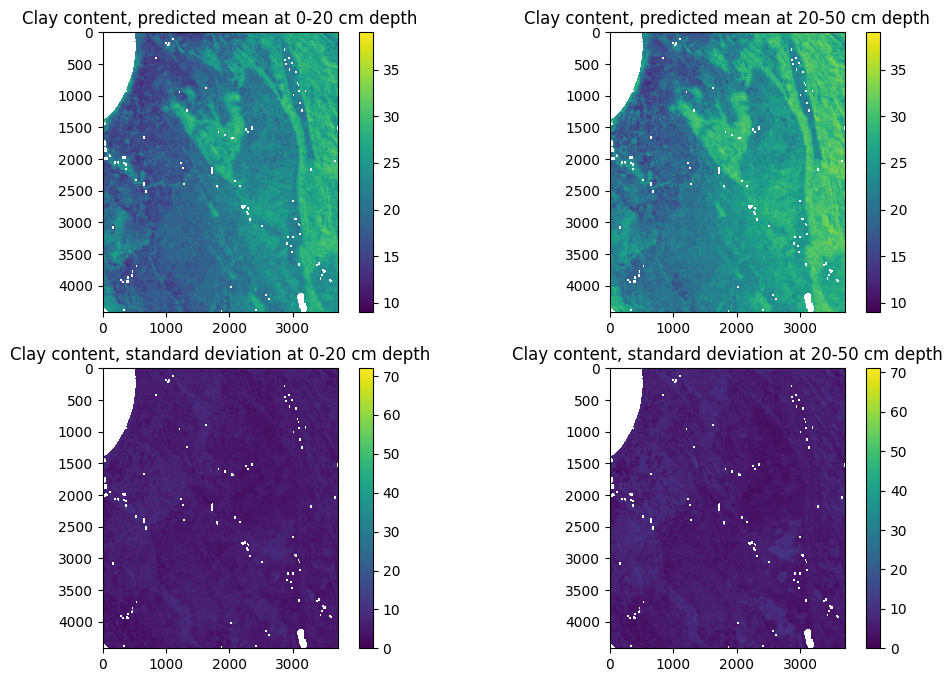

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(12,8), dpi= 100)   
count=0
for i in axs:
        for y in i:
            img = y.imshow(clay_data[count])
            fig.colorbar(img, ax=y)
            y.set_title(bands[count])
            count+=1

## Conclusions

We can see less fertility constraints and higher clay content on the agricultural lands. 

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [12]:
print(datacube.__version__)

1.8.8


**Last Tested:**

In [13]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2023-01-19'